In [203]:
import pandas as pd  
import base64
from io import BytesIO
from PIL import Image  
import numpy as np  
import openpyxl  
import jieba.posseg as pseg
import tqdm
import pickle
import wordcloud
from wordcloud import WordCloud 
import matplotlib.pyplot as plt  
import matplotlib.colors as colors
from pathlib import Path
import os
import re
from snownlp import SnowNLP
from  wordcloud import ImageColorGenerator
from imageio import imread
from IPython.display import display, HTML
from PIL import Image, ImageDraw, ImageFont
from gensim import corpora, models
from collections import defaultdict
import jieba
import networkx as nx
f=open('./stopwords.txt','r')
all_stop_words=f.readlines()
all_stop_words=[i.replace('\n','') for i in all_stop_words]
def df_to_dict(df:pd.DataFrame):
    columns=df.columns[1:]
    r=[{} for i in range(len(df))]
    for i in range(len(df)):
        for u in columns:
            r[i][u]=df[u][i]
    return r
def get_topic(text,num=5):
    words = jieba.cut(text)
    # 去除停用词，可以根据实际情况扩展停用词表
    stop_words = set(all_stop_words)
    filtered_words = [word.strip() for word in words if word.strip() not in stop_words and len(word.strip()) > 1]
    # 统计词频
    word_freq = defaultdict(int)
    for word in filtered_words:
        word_freq[word] += 1
    # 根据词频构建词袋
    texts = [[word for word in filtered_words]]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    # 训练LDA模型
    lda_model = models.LdaModel(corpus, num_topics=1, id2word=dictionary)
    # 提取主题
    topics = lda_model.print_topics(num_words=num)
    topics={i.split('*')[1].replace('"','').replace(' ',''):float(i.split('*')[0]) for i in topics[0][1].split('+')}
    return topics
def remove_brackets_and_content(input_str):
    # 定义匹配中括号及其内容的正则表达式
    pattern = r'\[[^\[\]]*\]'
    # 使用 re.sub 函数将匹配到的内容替换为空字符串
    result = re.sub(pattern, '', input_str)
    return result
def get_chinese(text):
    chinese_pattern = re.compile(r'[\u4e00-\u9fa5，。？！；：、]+')
    result = chinese_pattern.findall(text)
    chinese_text = (''.join(result)).replace('？','。')
    return chinese_text
def generate_co_occurrence_img(co_occurrence_matrix,path):
    # 创建一个空的无向图
    G = nx.Graph()
    # 添加节点和边到图中
    for word, related_words in co_occurrence_matrix.items():
        for related_word, weight in related_words.items():
            if not G.has_edge(word, related_word):
                G.add_edge(word, related_word, weight=weight)
    #绘制共词网络关系图
    pos = nx.spring_layout(G)  # 使用 Spring layout 算法布局节点
    #绘制节点
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    #绘制边
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    #绘制带有权重的边标签
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # 绘制节点标签（可选，根据需要添加）
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
    #显示图形
    plt.axis('off')
    plt.savefig(path)
    plt.show()
# 传入主题词，传入句子，句子含有主题词，返回True
def judge_if_topic(topic,text):
    words=pseg.lcut(text)
    words=[tuple(i) for i in words if tuple(i)[0] not in all_stop_words]
    frequency = defaultdict(int)
    for item in words:
        key, pos = item
        frequency[(key, pos)] += 1
    # 将结果转换为三元组列表
    result = [(key, pos, freq) for (key, pos), freq in frequency.items()]
    for i in range(len(result)):
        if(result[i][0]==topic):
            return (True,result)
    # 使用 defaultdict 来统计每个项的出现次数
    return (False,None)
def save_dict(dictionary, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(dictionary, file)
def load_dict(file_path):
    with open(file_path, 'rb') as file:
        dictionary = pickle.load(file)
    return dictionary
def draw_circular(sizes,labels):
    plt.rcParams['font.sans-serif'] = str(Path('KaiTi'))
    inner_radius = 0.5  # 内圈半径，0为饼图，大于0为环形图
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, radius=1)
    ax.pie([100], colors=['white'], radius=inner_radius)  # 内圈，白色填充
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')
    return fig
def which_attr(attr):
    if(attr in ['n','nr','ns','nt','nz','nx']):
        return '名词'
    elif(attr in ['v','vd','vn','vshi','vyou']):
        return '动词'
    elif(attr in ['a','ad','an']):
        return '形容词'
    elif(attr in ['d']):
        return '副词'
    else:
        return '其他词性'

## 百万的分析

In [204]:
comment_dcit=df_to_dict(pd.read_excel('./t_comments.xlsx'))
video_comments={}
video_combined_comments={}
all_video_text=''
# 这里按照视频对评论进行归类
for ind in range(len(comment_dcit)):
    reply=remove_brackets_and_content(comment_dcit[ind]['reply'])
    reply=get_chinese(reply)
    try:
        video_comments[comment_dcit[ind]['aid']].append(reply)
    except Exception as e:
        video_comments[comment_dcit[ind]['aid']]=[reply]
    try:
        video_combined_comments[comment_dcit[ind]['aid']]+=reply
    except Exception as e:
        video_combined_comments[comment_dcit[ind]['aid']]=reply
    all_video_text+=reply

In [205]:
topics=get_topic(all_video_text,50)

#### 给出主题词在所有项目中占的比例

In [206]:
topic_single_keywords={}
topic_combined_keywords={}
for topic,size in topics.items():# 每个主题分析
    print('\r'+topic,end='')
    topic_single_keywords[topic]=[]
    topic_combined_keywords[topic]=[]
    iii=0
    for video,comments in video_combined_comments.items():#每个视频分析
        print('\r'+str(iii)+'/'+str(len(video_combined_comments)),end='')
        iii+=1
        r=judge_if_topic(topic,comments)
        if(r[0]):
            topic_combined_keywords[topic].append({'video':video,'keywords':r[1]})
    for video,comments in video_comments.items():
        key_words=[]
        for comment in comments:
            r=judge_if_topic(topic,comment)
            if(r[0]):
                key_words.append(r[1])
        topic_single_keywords[topic].append({'video':video,'keywords':key_words})

307/308

#### 得到的数据

In [221]:
topics={'教育':0.014,'国家':0.0134,'支持':0.011,'农业':0.0104,'工作':0.0101,'城市':0.0097}

#### 生成主题

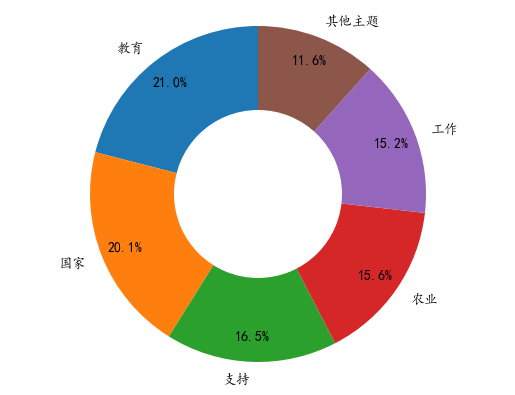

In [223]:
def generate_topic_chart(topics,keywords):
    top_6_topic=[]
    top_6_sizes=[]
    top_6_s=[]
    iii=0
    for topic,size in topics.items():
        if(iii<5):
            top_6_topic.append(topic)
            top_6_sizes.append(15*size)
            iii+=1
        else:
            top_6_topic.append('其他主题')
            top_6_sizes.append(1-sum(top_6_sizes))
            top_6_s.append(sum(top_6_s)//len(top_6_s))
            break     
        num=0
        for i in topic_combined_keywords[topic]:
            num+=len(i['keywords'])
        top_6_s.append(num//len(topic_combined_keywords[topic]))
    dcit=[]
    for i in range(6):
        d={}
        d['主题']=top_6_topic[i]
        d['占比']=top_6_sizes[i]
        d['关键词数']=top_6_s[i]
        dcit.append(d)
    pd.DataFrame(dcit).to_excel('./t/主词总体表.xlsx')
    draw_circular(top_6_sizes,top_6_topic).savefig('./t/百万主题占比.png')
    return top_6_topic,top_6_sizes,top_6_s
top_6_topic,top_6_sizes,top_6_s=generate_topic_chart(topics,topic_single_keywords)

#### 每个主题下的共现词列表

In [224]:
def merge_and_sum_tuples(tuple_list):
    merged_dict = {}
    for item in tuple_list:
        key = item[0]
        value = item[2]
        if key in merged_dict:
            merged_dict[key] += value
        else:
            merged_dict[key] = value
    merged_list = [(key, 'ns', value) for key, value in merged_dict.items()]
    return merged_list

In [225]:
topic_top_20_keywords=[]
topic_keywords_list=[]
for topic in top_6_topic[:5]:
    keywords_list=[]
    for i in topic_combined_keywords[topic]:
        keywords_list+=i['keywords']
    keywords_list=merge_and_sum_tuples(keywords_list)
    keywords_list=[i for i in keywords_list if len(i[0])>1 and topic!=i[0]]
    keywords_list=sorted(keywords_list,key=lambda x:x[2],reverse=True)[:20]
    topic_keywords_list.append((topic,keywords_list))

In [226]:
for item in topic_keywords_list:
    topic=item[0]
    key_words=item[1]
    df=[]
    for i in key_words:
        tmp={}
        tmp['共现词']=i[0]
        tmp['词性']=which_attr(i[1])
        tmp['共现次数']=i[2]
        df.append(tmp)
    df=pd.DataFrame(df)
    df.to_excel('./t/'+topic+'前20共现词表'+'.xlsx')

#### 画共词关系图

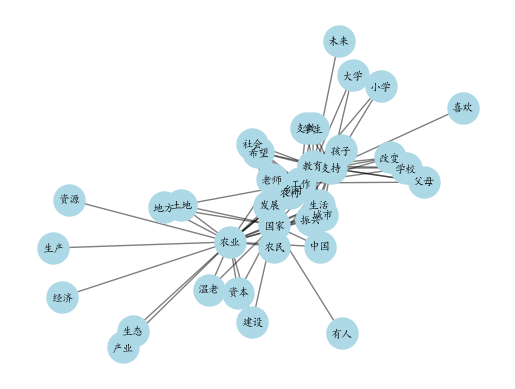

In [227]:
matrix={}
for item in topic_keywords_list:
    matrix[item[0]]={}
    for i in item[1]:
        matrix[item[0]][i[0]]=i[2]
generate_co_occurrence_img(matrix,'./t/共词关系图.png')

#### 情感分析

In [228]:
topics

{'教育': 0.014,
 '国家': 0.0134,
 '支持': 0.011,
 '农业': 0.0104,
 '工作': 0.0101,
 '城市': 0.0097}

In [229]:
topic_emotion_size=[]
for topic,_ in topics.items():
    print(topic)
    keywords=topic_combined_keywords[topic]
    pos_num=0
    neu_num=0
    neg_num=0
    for i in keywords:
        for i2 in i['keywords']:
            emotion=SnowNLP(i2[0]).sentiments
            if(emotion<=0.33):
                neg_num+=1
            elif(emotion>0.5):
                pos_num+=1
            else:
                neu_num+=10
    topic_emotion_size.append((topic,(pos_num,neu_num,neg_num)))

教育
国家
支持
农业
工作
城市


In [230]:
def generate_percent_bar(sizes):
    img=Image.new('RGB',size=(1200,80))
    pixels=img.load()
    neutral_color=(249,149,0)
    postive_color=(44,186,41)
    negative_color=(254,77,75)
    s=sum(sizes)
    pos=int((sizes[0]/s)*1200)
    neu=int((sizes[1]/s)*1200)+pos
    # 遍历每一个像素，并设置其颜色
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            if(i<pos):
                pixels[i, j] = postive_color
            elif(i<neu):
                pixels[i, j] = neutral_color
            else:
                pixels[i,j] = negative_color
    pos_mid=pos//2
    neu_mid=(pos+neu)//2
    neg_mid=(neu+1200)//2
    pos_percentage=round(100*sizes[0]/s,1)
    neu_percentage=round(100*sizes[1]/s,1) 
    neg_percentage=round(100*sizes[2]/s,1)  
    pos_text='正面('+str(pos_percentage)+'%)'
    neu_text='中性('+str(neu_percentage)+'%)'
    neg_text='负面('+str(neg_percentage)+'%)'
    pos_draw_pos=(0 if pos_mid-50<0 else pos_mid-50,27)
    neu_draw_pos=(pos if neu_mid-50<pos else neu_mid-50,27)
    neg_draw_pos=(neu if neg_mid-50<neu else neg_mid-50,27)
    font = ImageFont.truetype("./KT.ttf", size=20) 
    draw = ImageDraw.Draw(img)
    draw.text(pos_draw_pos,pos_text,font=font,fill=(255,255,255))
    draw.text(neu_draw_pos,neu_text,font=font,fill=(255,255,255))
    draw.text(neg_draw_pos,neg_text,font=font,fill=(255,255,255))
    return img 

In [231]:
topic_emotion_size

[('教育', (12138, 57290, 1903)),
 ('国家', (15720, 84690, 2929)),
 ('支持', (10639, 56790, 1991)),
 ('农业', (13418, 77190, 2604)),
 ('工作', (15429, 83080, 2832)),
 ('城市', (15131, 83880, 2896))]

In [216]:
for i in topic_emotion_size:
    generate_percent_bar(i[1]).save('./t/'+i[0]+'情感占比条状图.png')